In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
config = tf.ConfigProto(gpu_options=gpu_options)

In [3]:
def segment_(data,window_size = 40):
    segments = np.empty((0,1,window_size,3))
    labels = np.empty((0))
    for line in data:
        line = np.array(line).reshape(1,1,window_size,3)
        segments = np.vstack([segments,line])
    return segments

# init nn parameters
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

# conv
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

# load data

In [6]:
fault_label = {'1': 'info',
               '2': 'Critical',
               '3': 'error',
               '4': 'notice',
               '5': 'warning',
               '6': 'alert',
               '7': 'emergency'}

X, X_val, labels, labels_val = [], [], [], [] #validation set features

with open("data/msg_token_train.txt", 'rU') as f:
        res = list(f)
        for line in res:
            line.strip("\n")
            features = line.split("\t")
            while features.__contains__(""):
                features.remove("")
            for i in range(len(features)):
                features[i] = float(features[i])
            X.append(features)
            
with open("data/msg_label_train.txt", 'rU') as f:
        res = list(f)
        for line in res:
            labels.append(int(line.strip("\n")[0]))
            
with open("data/msg_token_test.txt", 'rU') as f:
        res = list(f)
        for line in res:
            line.strip("\n")
            features = line.split("\t")
            while features.__contains__(""):
                features.remove("")
            for i in range(len(features)):
                features[i] = float(features[i])
            X_val.append(features)
            
with open("data/msg_label_test.txt", 'rU') as f:
        res = list(f)
        for line in res:
            labels_val.append(int(line.strip("\n")[0]))

segments = segment_(X)
segments_val = segment_(X_val)
print(segments.shape)

labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
labels_val = np.asarray(pd.get_dummies(labels_val), dtype = np.int8)
print(labels.shape)

train_x = segments.reshape(len(segments), 1, 40, 3)
train_y = labels
test_x = segments_val.reshape(len(segments_val), 1, 40, 3)
test_y = labels_val

# Separate our training data into test and training.
print("Separating data into 67% training set & 33% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    train_x, train_y, test_size=0.33, random_state=33)#add random state here...
print("Dataset separated.\n")

ValueError: cannot reshape array of size 120 into shape (0,1,40,3)

# define parameters

In [11]:
input_height = 1
input_width = 40
num_channels = 3
num_labels = 7

batch_size = 10
kernel_size = 20
depth = 20
num_hidden = 1000

learning_rate = 0.0001
# iteration times
training_epochs = 8

total_batches = train_x.shape[0] // batch_size

# build network

In [12]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,10,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

# loss func
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_history = np.empty(shape=[1], dtype=float)

# train and test

In [14]:
with tf.Session(config=config) as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print "Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", \
          session.run(accuracy, feed_dict={X: train_x, Y: train_y})
    y_pred = tf.argmax(y_, 1)
    y_true = np.argmax(test_y, 1)
    final_acc, y_pred = session.run([accuracy, y_pred], feed_dict={X: test_x, Y: test_y})
    print "Testing Accuracy: {}".format(final_acc)
    print()
    
    # model metrics
    temp_y_true = np.unique(y_true)
    temp_y_pred = np.unique(y_pred) 
    np.save("data/y_true", y_true) 
    np.save("data/y_pred", y_pred) 
    print "temp_y_true", temp_y_true 
    print "temp_y_pred", temp_y_pred
    
    print(classification_report(y_true, y_pred, 
                                target_names = fault_label.values()))
    print("confusion_matrix: ")
    print confusion_matrix(y_true, y_pred)

Epoch:  0  Training Loss:  8.28069  Training Accuracy:  0.416354
Epoch:  1  Training Loss:  8.28183  Training Accuracy:  0.416354
Epoch:  2  Training Loss:  8.27194  Training Accuracy:  0.416354
Epoch:  3  Training Loss:  8.24163  Training Accuracy:  0.416354
Epoch:  4  Training Loss:  8.21352  Training Accuracy:  0.416354
Epoch:  5  Training Loss:  8.27362  Training Accuracy:  0.416354
Epoch:  6  Training Loss:  8.2745  Training Accuracy:  0.416354
Epoch:  7  Training Loss:  8.27537  Training Accuracy:  0.416354
Testing Accuracy: 0.413918107748
()
temp_y_true [0 1 2 3 4 5 6]
temp_y_pred [0]
             precision    recall  f1-score   support

       info       0.41      1.00      0.59      1142
      error       0.00      0.00      0.00       178
   Critical       0.00      0.00      0.00       157
    warning       0.00      0.00      0.00        60
     notice       0.00      0.00      0.00      1215
  emergency       0.00      0.00      0.00         1
      alert       0.00      0

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# confusion matrix

             precision    recall  f1-score   support

       info       0.41      1.00      0.59      1142
      error       0.00      0.00      0.00       178
   Critical       0.00      0.00      0.00       157
    warning       0.00      0.00      0.00        60
     notice       0.00      0.00      0.00      1215
  emergency       0.00      0.00      0.00         1
      alert       0.00      0.00      0.00         6

avg / total       0.17      0.41      0.24      2759

<function confusion_matrix at 0x7f00c8da7b90>
[[1142    0    0    0    0    0    0]
 [ 178    0    0    0    0    0    0]
 [ 157    0    0    0    0    0    0]
 [  60    0    0    0    0    0    0]
 [1215    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0]
 [   6    0    0    0    0    0    0]]
()
confusion_matrix: 
[[  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.55866900e-01   0.00000000e+00   0.00000000e+00   0.0000

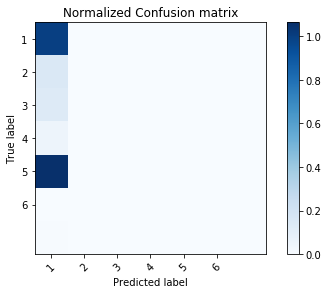

In [15]:
def plot_confusion_matrix(cm, title='Normalized Confusion matrix', 
                          cmap=plt.cm.get_cmap("Blues")): 
    cm = cm / cm.astype(np.float).sum(axis=1) 
    print "confusion_matrix: \n{}".format(cm) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    plt.colorbar() 
    tick_marks = np.arange(6) 
    plt.xticks(tick_marks, [1, 2, 3, 4, 5, 6], rotation=45) 
    plt.yticks(tick_marks, [1, 2, 3, 4, 5, 6]) 
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    plt.show()

def test_har(): 
    y_true = np.load("data/y_true.npy") 
    y_pred = np.load("data/y_pred.npy") 
    print(classification_report(y_true, y_pred, 
                                target_names = fault_label.values()))
    print(confusion_matrix)
    print(confusion_matrix(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    test_har()